 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

Epoch 1, Loss: 0.0046


 20%|██        | 2/10 [00:10<00:44,  5.52s/it]

Epoch 2, Loss: 0.0018


 30%|███       | 3/10 [00:16<00:37,  5.42s/it]

Epoch 3, Loss: 0.0018


 40%|████      | 4/10 [00:21<00:32,  5.44s/it]

Epoch 4, Loss: 0.0017


 50%|█████     | 5/10 [00:27<00:27,  5.46s/it]

Epoch 5, Loss: 0.0017


 60%|██████    | 6/10 [00:32<00:22,  5.53s/it]

Epoch 6, Loss: 0.0017


 70%|███████   | 7/10 [00:38<00:16,  5.57s/it]

Epoch 7, Loss: 0.0017


 80%|████████  | 8/10 [00:44<00:11,  5.59s/it]

Epoch 8, Loss: 0.0017


 90%|█████████ | 9/10 [00:49<00:05,  5.62s/it]

Epoch 9, Loss: 0.0017


100%|██████████| 10/10 [00:55<00:00,  5.54s/it]

Epoch 10, Loss: 0.0017


<Axes: >

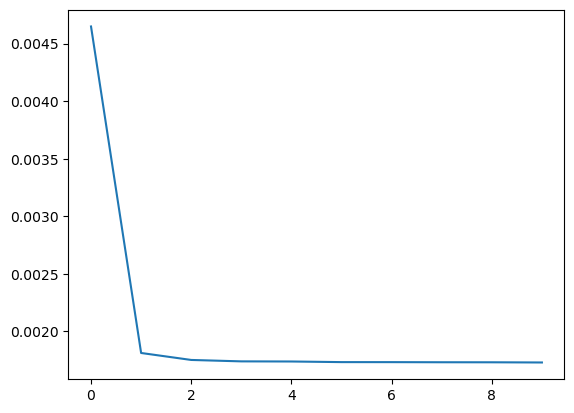

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns

# 定义CVAE模型
class CVAE(nn.Module):
    def __init__(self, input_dim=28*28, z_dim=20, n_classes=10, hidden_dim=400):
        super().__init__()
        
        # 编码器
        self.fc1 = nn.Linear(input_dim + n_classes, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)  # 均值向量
        self.fc22 = nn.Linear(hidden_dim, z_dim)  # 方差向量
        
        # 解码器
        self.fc3 = nn.Linear(z_dim + n_classes, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x, y):
        '''编码器'''
        input_combined = torch.cat([x, y], dim=1)
        h1 = self.relu(self.fc1(input_combined))
        z_mu = self.fc21(h1)
        z_logvar = self.fc22(h1)
        return z_mu, z_logvar

    def reparameterize(self, mu, logvar):
        '''重参数技巧'''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z, y):
        '''解码器
        ---
        :param z: 隐空间向量
        :param y: 条件
        '''
        input_combined = torch.cat([z, y], dim=1)
        h3 = self.relu(self.fc3(input_combined))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        z_mu, z_logvar = self.encoder(x, y)
        z = self.reparameterize(z_mu, z_logvar)
        return self.decoder(z, y), z_mu, z_logvar

# CVAE损失函数
def loss_function(recon_x, x, mu, logvar):
    # x = (x + 1) / 2
    MSE = nn.functional.binary_cross_entropy(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# * 模型参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 30
n_classes = 10  # 数字0到9
hidden_dim = 128
model = CVAE(z_dim=z_dim, n_classes=n_classes, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 加载MNIST数据集
batch_size = 128  # * 调整批量大小观察效果
train_dataset = datasets.MNIST(root='../../data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

loss_list = []
# 训练模型
epochs = 10
for epoch in trange(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, 28*28).to(device)
        labels_onehot = torch.eye(10)[labels].to(device)  # 将标签转换为one-hot编码

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels_onehot)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    loss_list += [train_loss / len(train_loader.dataset)]
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

# 打印损失
sns.lineplot(loss_list)

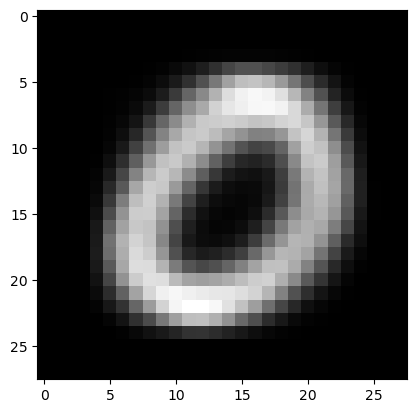

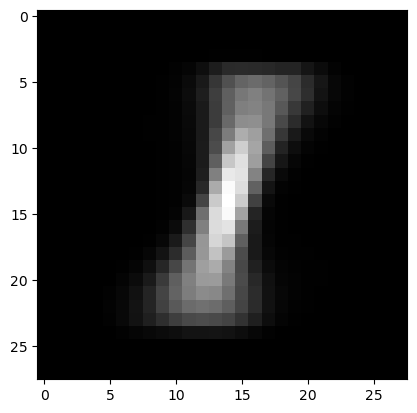

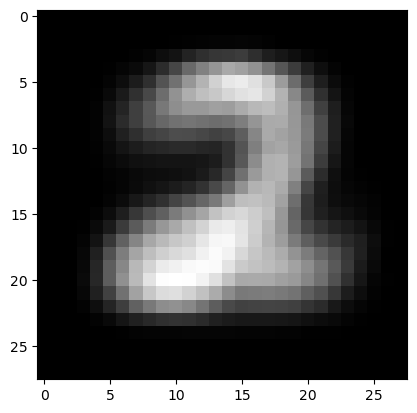

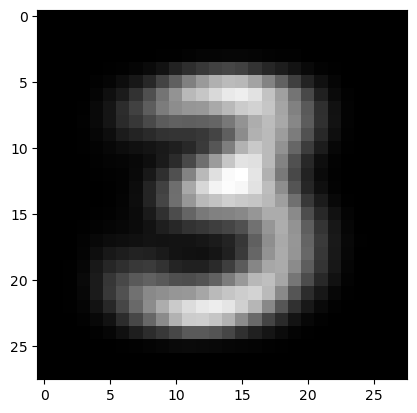

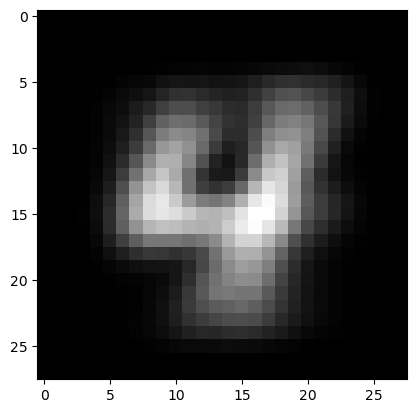

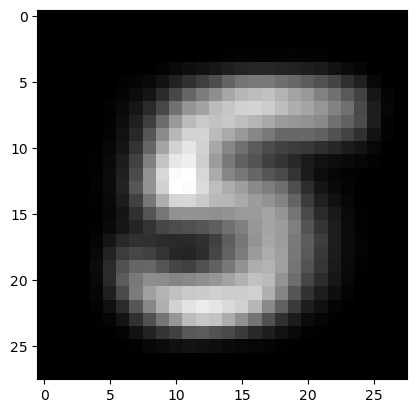

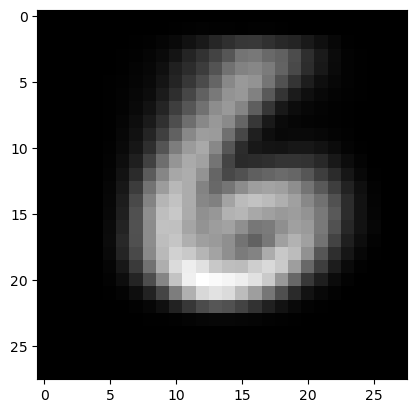

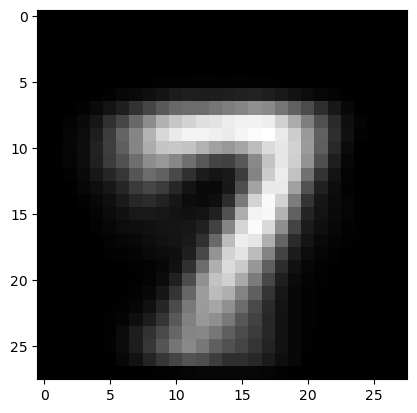

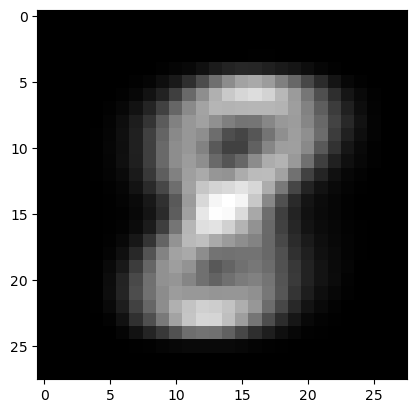

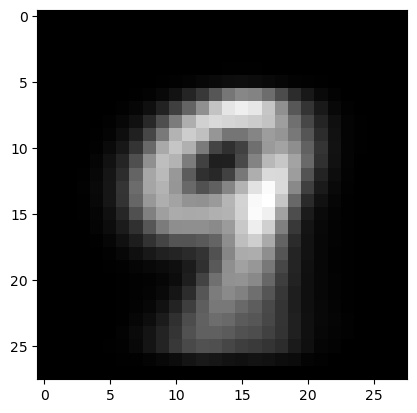

In [21]:
# 生成图片
def generate_image(model, label, z_dim=20):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, z_dim).to(device)
        label_onehot = torch.eye(10)[label].unsqueeze(0).to(device)
        generated_img = model.decoder(z, label_onehot).cpu().view(28, 28)
        return generated_img

# 生成指定数字的图片
for label in range(0, 10):
    generated_img = generate_image(model, label, z_dim)
    plt.imshow(generated_img, cmap="gray")
    plt.show()